In [ ]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    "claude-sonnet-4-5-20250929",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)



In [2]:
tools_by_name

{'add': StructuredTool(name='add', description='Adds `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x757b863b62a0>),
 'multiply': StructuredTool(name='multiply', description='Multiply `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x757b86c77c40>),
 'divide': StructuredTool(name='divide', description='Divide `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x757b863b4d60>)}

In [3]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int


In [7]:
from langchain.messages import SystemMessage

def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
               [
                   SystemMessage(
                       content="You are a helpful assistant tasked with performing arithmatic on a set of inputs."
                   )
               ] 
               + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [4]:
from langchain.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))

    return {"messages": result}

In [5]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def should_continue(state: MessageState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    #If LLM makes a tool call , then perform an action
    if last_message.tool_calls:
        return "tool_node"
    
    #Otherwise , we stop(reply to the user)
    return END


In [8]:
agent_builder = StateGraph(MessageState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node","llm_call")

agent = agent_builder.compile()

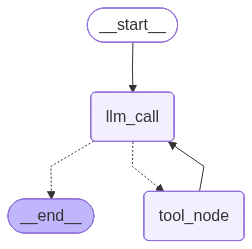

NameError: name 'model_with_tools' is not defined

In [9]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()